In [1]:
import pymc as pm
from scipy.stats import poisson
from itertools import product
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import poisson
import sqlite3

goals = pd.read_csv("goals.csv")
shots = pd.read_csv("shots.csv")
red_cards =pd.read_csv("red_cards.csv")

goals["days_ago"] = (pd.to_datetime(goals["match_date"]).max() - pd.to_datetime(goals["match_date"])).dt.days
shots["days_ago"] = (pd.to_datetime(shots["match_date"]).max() - pd.to_datetime(shots["match_date"])).dt.days

shots

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


,round,match_date,home_team,away_team,match_url,player_name,team_name,side,minute,xg,xgot,result,days_ago
0,1,2024-08-17,Everton,Brighton & Hove Albion,https://www.fotmob.com/en-GB/matches/everton-v...,Simon Adingra,Brighton & Hove Albion,away,87,0.07,0.47,Goal,281
1,1,2024-08-17,Everton,Brighton & Hove Albion,https://www.fotmob.com/en-GB/matches/everton-v...,Jack Harrison,Everton,home,4,0.03,0.05,Attempt saved,281
2,1,2024-08-17,Everton,Brighton & Hove Albion,https://www.fotmob.com/en-GB/matches/everton-v...,Joao Pedro,Brighton & Hove Albion,away,9,0.03,NaN,Post,281
3,1,2024-08-17,Everton,Brighton & Hove Albion,https://www.fotmob.com/en-GB/matches/everton-v...,Jack Harrison,Everton,home,12,0.05,NaN,Miss,281
4,1,2024-08-17,Everton,Brighton & Hove Albion,https://www.fotmob.com/en-GB/matches/everton-v...,James Tarkowski,Everton,home,14,0.01,NaN,Miss,281
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9839,38,2025-05-25,Wolverhampton Wanderers,Brentford,https://www.fotmob.com/en-GB/matches/wolverham...,Matheus Cunha,Wolverhampton Wanderers,home,54,0.10,NaN,Blocked,0
9840,38,2025-05-25,Wolverhampton Wanderers,Brentford,https://www.fotmob.com/en-GB/matches/wolverham...,Goncalo Guedes,Wolverhampton Wanderers,home,57,0.20,NaN,Miss,0
9841,38,2025-05-25,Wolverhampton Wanderers,Brentford,https://www.fotmob.com/en-GB/matches/wolverham...,Christian Nørgaard,Brentford,away,63,0.04,0.24,Attempt saved,0
9842,38,2025-05-25,Wolverhampton Wanderers,Brentford,https://www.fotmob.com/en-GB/matches/wolverham...,Joao Gomes,Wolverhampton Wanderers,home,68,0.06,NaN,Miss,0


In [2]:
team_totals = shots.groupby("team_name")["xg"].sum()

team_totals

team_name
AFC Bournemouth            65.75
Arsenal                    62.25
Aston Villa                57.66
Brentford                  60.97
Brighton & Hove Albion     59.60
Chelsea                    69.80
Crystal Palace             61.76
Everton                    43.06
Fulham                     48.16
Ipswich Town               35.21
Leicester City             35.60
Liverpool                  84.56
Manchester City            71.42
Manchester United          53.00
Newcastle United           63.50
Nottingham Forest          44.89
Southampton                33.36
Tottenham Hotspur          59.67
West Ham United            56.56
Wolverhampton Wanderers    42.78
Name: xg, dtype: float64

In [9]:

def poisson_binomial_pmf(k, p_values):
    """
    Calculate PMF of Poisson-Binomial distribution for k successes
    given array of success probabilities p_values
    
    Uses dynamic programming approach for efficiency
    """
    n = len(p_values)
    if k > n or k < 0:
        return 0.0
    
    # Dynamic programming table
    # dp[i][j] = probability of exactly j successes using first i trials
    dp = np.zeros((n + 1, k + 1))
    dp[0][0] = 1.0  # Base case: 0 trials, 0 successes
    
    for i in range(1, n + 1):
        p = p_values[i - 1]
        dp[i][0] = dp[i - 1][0] * (1 - p)  # 0 successes
        
        for j in range(1, min(i, k) + 1):
            # j successes = (j successes from first i-1, no success on trial i) +
            #               (j-1 successes from first i-1, success on trial i)
            dp[i][j] = dp[i - 1][j] * (1 - p) + dp[i - 1][j - 1] * p
    
    return dp[n][k]

def simulate_shots_poisson_binomial(xg_values, max_goals=None):
    """
    Simulate goal probabilities using Poisson-Binomial distribution
    
    Args:
        xg_values: array of xG values for individual shots
        max_goals: maximum number of goals to consider (default: number of shots)
    
    Returns:
        dict with goals as keys and probabilities as values
    """
    if len(xg_values) == 0:
        return {0: 1.0}
    
    if max_goals is None:
        max_goals = len(xg_values)
    
    goal_probs = {}
    for goals in range(max_goals + 1):
        prob = poisson_binomial_pmf(goals, xg_values)
        if prob > 1e-10:  # Only keep non-negligible probabilities
            goal_probs[goals] = prob
    
    return goal_probs

def simulate_game_poisson_binomial(home_xg_shots, away_xg_shots, max_goals=9):
    """
    Simulate a game using Poisson-Binomial distribution for each team
    
    Args:
        home_xg_shots: array of xG values for home team shots
        away_xg_shots: array of xG values for away team shots
        max_goals: maximum goals to consider for each team
    
    Returns:
        list of dicts with home_goals, away_goals, and probability
    """
    home_probs = simulate_shots_poisson_binomial(home_xg_shots, max_goals)
    away_probs = simulate_shots_poisson_binomial(away_xg_shots, max_goals)
    
    game_probs = []
    for (h_goals, h_prob), (a_goals, a_prob) in product(home_probs.items(), away_probs.items()):
        combined_prob = h_prob * a_prob
        if combined_prob > 1e-6:  # Filter very small probabilities
            game_probs.append({
                'home_goals': h_goals,
                'away_goals': a_goals,
                'probability': combined_prob
            })
    
    return game_probs

def create_weighted_scoreline_data_poisson_binomial(
    df, 
    shot_data, 
    max_goals=9, 
    actual_scoreline_boost=0.3,
    min_prob_threshold=0.001,
    decay_rate=0.001
):
    """
    Create expanded dataset with all possible scorelines using both Poisson-Binomial 
    and Poisson distributions for comparison
    """
    from scipy.stats import poisson
    
    expanded_data = []
    
    for idx, row in df.iterrows():
        match_id = row['match_url']
        
        # Get shot data for this match
        match_shots = shot_data[shot_data['match_url'].str.replace(":tab=stats", "") == match_id]
        
        if match_shots.empty:
            print(f"Warning: No shot data found for match_id {match_id}")
            continue
            
        home_xg_shots = match_shots[match_shots['side'] == 'home']['xg'].values
        away_xg_shots = match_shots[match_shots['side'] == 'away']['xg'].values
        
        # Calculate total xG for each team
        home_total_xg = home_xg_shots.sum()
        away_total_xg = away_xg_shots.sum()
        
        # Generate scorelines with Poisson-Binomial (individual shots)
        game_probs_pb = simulate_game_poisson_binomial(home_xg_shots, away_xg_shots, max_goals)
        
        # Generate scorelines with regular Poisson (total xG)
        home_poisson_probs = {i: poisson.pmf(i, home_total_xg) for i in range(max_goals + 1)}
        away_poisson_probs = {i: poisson.pmf(i, away_total_xg) for i in range(max_goals + 1)}
        
        # Create lookup for Poisson-Binomial probabilities
        pb_prob_lookup = {(sp['home_goals'], sp['away_goals']): sp['probability'] 
                         for sp in game_probs_pb}
        
        # Get actual scoreline
        actual_home = int(row['home_goals'])
        actual_away = int(row['away_goals'])
        
        # Store match scorelines temporarily
        match_scorelines = []
        
        # Iterate through all possible scorelines
        for home_goals in range(max_goals + 1):
            for away_goals in range(max_goals + 1):
                
                # Get probabilities from both methods
                pb_prob = pb_prob_lookup.get((home_goals, away_goals), 0.0)
                poisson_prob = home_poisson_probs[home_goals] * away_poisson_probs[away_goals]
                
                # Skip if both probabilities are negligible
                if pb_prob < 1e-10 and poisson_prob < 1e-10:
                    continue
                
                # Check if this is the actual scoreline
                is_actual = (home_goals == actual_home and away_goals == actual_away)
                
                match_scorelines.append({
                    'match_id': match_id,
                    'home_team': row['home_team'],
                    'away_team': row['away_team'],
                    'home_goals': home_goals,
                    'away_goals': away_goals,
                    'days_ago': row['days_ago'],
                    'is_actual': is_actual,
                    'pb_prob_raw': pb_prob,
                    'poisson_prob_raw': poisson_prob,
                })
        
        if not match_scorelines:
            continue
            
        # Filter by minimum probability threshold BEFORE normalization
        filtered_scorelines = []
        for scoreline in match_scorelines:
            # Use a simple threshold on raw probabilities or keep actual scoreline
            if (scoreline['pb_prob_raw'] >= min_prob_threshold or 
                scoreline['poisson_prob_raw'] >= min_prob_threshold or 
                scoreline['is_actual']):
                filtered_scorelines.append(scoreline)
        
        # NOW normalize probabilities within the filtered set
        total_pb_prob = sum(s['pb_prob_raw'] for s in filtered_scorelines)
        total_poisson_prob = sum(s['poisson_prob_raw'] for s in filtered_scorelines)
        
        for scoreline in filtered_scorelines:
            scoreline['poisson_binomial_prob'] = scoreline['pb_prob_raw'] / total_pb_prob if total_pb_prob > 0 else 0
            scoreline['poisson_prob'] = scoreline['poisson_prob_raw'] / total_poisson_prob if total_poisson_prob > 0 else 0
        
        # Calculate remaining weight after actual scoreline boost
        remaining_weight = 1.0 - actual_scoreline_boost
        
        # Apply weighting
        for scoreline in filtered_scorelines:
            normalized_pb_prob = scoreline['poisson_binomial_prob']
            normalized_p_prob = scoreline["poisson_prob"]
            
            # Calculate weights (using Poisson-Binomial for the main weighting)
            if scoreline['is_actual']:
                final_weight = actual_scoreline_boost + (remaining_weight * normalized_pb_prob)
            else:
                final_weight = remaining_weight * normalized_p_prob # testing match total for sense check
            
            # Time decay weight
            time_weight = np.exp(-decay_rate * scoreline['days_ago'])
            combined_weight = time_weight * final_weight
            
            expanded_data.append({
                'match_id': scoreline['match_id'],
                'home_team': scoreline['home_team'],
                'away_team': scoreline['away_team'],
                'home_goals': scoreline['home_goals'],
                'away_goals': scoreline['away_goals'],
                'weight': combined_weight,
                'days_ago': scoreline['days_ago'],
                'is_actual': scoreline['is_actual'],
                'poisson_binomial_prob': normalized_pb_prob,
                'poisson_prob': normalized_p_prob,
            })
    
    return pd.DataFrame(expanded_data)

# Example usage:

# With shot-level data:
df = create_weighted_scoreline_data_poisson_binomial(
    goals, 
    shots,
    max_goals=9,
    actual_scoreline_boost=0,
    decay_rate=0.0001
)

df

,match_id,home_team,away_team,home_goals,away_goals,weight,days_ago,is_actual,poisson_binomial_prob,poisson_prob
0,https://www.fotmob.com/en-GB/matches/fulham-vs...,Manchester United,Fulham,0,0,0.054863,282,False,0.019762,0.056432
1,https://www.fotmob.com/en-GB/matches/fulham-vs...,Manchester United,Fulham,0,1,0.024140,282,False,0.009137,0.024830
2,https://www.fotmob.com/en-GB/matches/fulham-vs...,Manchester United,Fulham,0,2,0.005311,282,False,0.001879,0.005463
3,https://www.fotmob.com/en-GB/matches/fulham-vs...,Manchester United,Fulham,1,0,0.107386,282,True,0.110458,0.137695
4,https://www.fotmob.com/en-GB/matches/fulham-vs...,Manchester United,Fulham,1,1,0.058901,282,False,0.051072,0.060586
...,...,...,...,...,...,...,...,...,...,...
11909,https://www.fotmob.com/en-GB/matches/wolverham...,Wolverhampton Wanderers,Brentford,4,0,0.004149,0,False,0.002437,0.004149
11910,https://www.fotmob.com/en-GB/matches/wolverham...,Wolverhampton Wanderers,Brentford,4,1,0.005933,0,False,0.005148,0.005933
11911,https://www.fotmob.com/en-GB/matches/wolverham...,Wolverhampton Wanderers,Brentford,4,2,0.004242,0,False,0.003884,0.004242
11912,https://www.fotmob.com/en-GB/matches/wolverham...,Wolverhampton Wanderers,Brentford,4,3,0.002022,0,False,0.001507,0.002022


In [10]:
teams = df["home_team"].unique()
n_teams = len(teams)
home_idx = pd.Categorical(df["home_team"], categories=teams).codes
away_idx = pd.Categorical(df["away_team"], categories=teams).codes


home_goals_obs = df["home_goals"]
away_goals_obs = df["away_goals"]

In [11]:
with pm.Model() as model:
    att_str_raw = pm.Normal("att_str_raw", mu=0, sigma=1, shape=n_teams)
    def_str_raw = pm.Normal("def_str_raw", mu=0, sigma=1, shape=n_teams)
     
    att_str = pm.Deterministic("att_str", att_str_raw - pm.math.mean(att_str_raw))
    def_str = pm.Deterministic("def_str", def_str_raw - pm.math.mean(def_str_raw))
    
    home_adv = pm.Beta("home_adv", alpha=3, beta=9)

    home_goals_mu = pm.math.exp(att_str[home_idx] + def_str[away_idx] + home_adv)
    away_goals_mu = pm.math.exp(att_str[away_idx] + def_str[home_idx])

    weights = pm.ConstantData("weights", df["weight"].values)
    
    home_logp = pm.logp(pm.Poisson.dist(mu=home_goals_mu), home_goals_obs)
    away_logp = pm.logp(pm.Poisson.dist(mu=away_goals_mu), away_goals_obs)

    pm.Potential("weighted_home_goals", pm.math.sum(weights * home_logp))
    pm.Potential("weighted_away_goals", pm.math.sum(weights * away_logp))

    trace = pm.sample(3000, tune=1500, cores=4, nuts_sampler='blackjax', return_inferencedata=True)

c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\sampling\jax.py:368: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(


                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
att_str_raw[0] -0.000  0.261  -0.480    0.506      0.010    0.007     715.0   
att_str_raw[1] -0.438  0.281  -0.968    0.081      0.010    0.007     818.0   
att_str_raw[2]  0.153  0.257  -0.348    0.635      0.010    0.007     678.0   
att_str_raw[3] -0.232  0.269  -0.740    0.269      0.010    0.007     733.0   
att_str_raw[4]  0.195  0.255  -0.279    0.682      0.010    0.007     671.0   
...               ...    ...     ...      ...        ...      ...       ...   
def_str[15]     0.212  0.127  -0.027    0.450      0.001    0.001   24688.0   
def_str[16]    -0.057  0.142  -0.314    0.224      0.001    0.001   20725.0   
def_str[17]    -0.084  0.149  -0.367    0.187      0.001    0.001   20918.0   
def_str[18]     0.112  0.128  -0.132    0.349      0.001    0.001   22824.0   
def_str[19]    -0.309  0.162  -0.619   -0.013      0.001    0.001   16269.0   

                ess_tail  r_hat  
att_str_raw[0]   

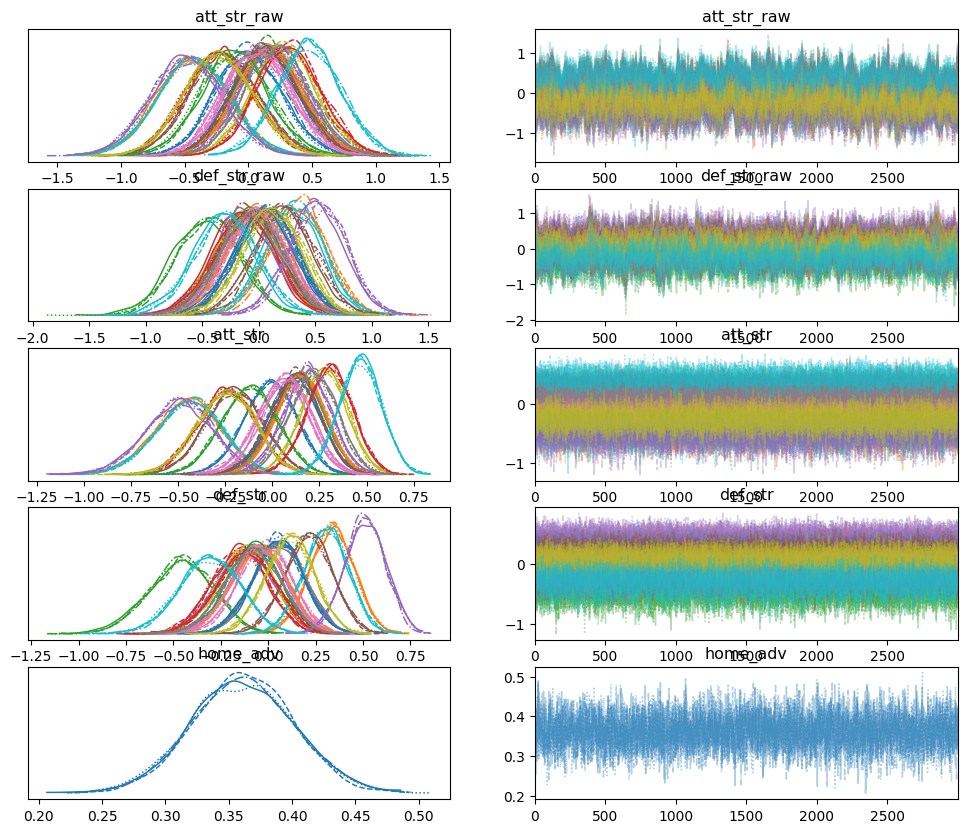

In [12]:
# Summary statistics for all parameters
az.summary(trace)

# Trace plots for all parameters
az.plot_trace(trace, var_names=[
    "att_str_raw", 
    "def_str_raw", 
    "att_str",     
    "def_str",            
    "home_adv"
])


print(az.summary(trace))

In [13]:

# Get team rankings
att_summary = az.summary(trace, var_names=["att_str"])
att_summary.index = teams
print("Attack Strength Rankings:")
print(att_summary[['mean', 'hdi_3%', 'hdi_97%']].sort_values("mean", ascending=False))

def_summary = az.summary(trace, var_names=["def_str"]) 
def_summary.index = teams
print("\nDefense Strength Rankings (lower is better):")
print(def_summary[['mean', 'hdi_3%', 'hdi_97%']].sort_values("mean", ascending=True))



Attack Strength Rankings:
                          mean  hdi_3%  hdi_97%
Liverpool                0.466   0.256    0.677
Manchester City          0.304   0.079    0.536
Chelsea                  0.273   0.039    0.501
AFC Bournemouth          0.217  -0.027    0.457
Newcastle United         0.182  -0.065    0.416
Crystal Palace           0.149  -0.092    0.393
Arsenal                  0.140  -0.109    0.376
Brentford                0.140  -0.099    0.391
Tottenham Hotspur        0.117  -0.125    0.371
Brighton & Hove Albion   0.114  -0.137    0.361
Aston Villa              0.074  -0.178    0.323
West Ham United          0.048  -0.216    0.306
Manchester United       -0.013  -0.275    0.252
Fulham                  -0.123  -0.395    0.159
Nottingham Forest       -0.204  -0.508    0.067
Everton                 -0.245  -0.531    0.042
Wolverhampton Wanderers -0.248  -0.546    0.037
Leicester City          -0.442  -0.782   -0.118
Ipswich Town            -0.450  -0.789   -0.134
Southampton   

In [14]:
import numpy as np

# With sum-to-zero constraints, league average is simply 0
att_league_avg = 0.0
def_league_avg = 0.0
home_adv_mean = az.summary(trace, var_names=["home_adv"])['mean'].iloc[0]

print(f"League average attack strength: {att_league_avg:.3f}")
print(f"League average defense strength: {def_league_avg:.3f}")
print(f"Home advantage: {home_adv_mean:.3f}")

def convert_to_expected_goals_constrained(att_summary, def_summary, home_adv):
    results = []
    
    for team in teams:
        team_att = att_summary.loc[team, 'mean']
        team_def = def_summary.loc[team, 'mean']
        
        # Expected goals FOR this team vs league average opponent
        goals_for_home = np.exp(team_att + def_league_avg + home_adv)
        goals_for_away = np.exp(team_att + def_league_avg)
        
        # Expected goals AGAINST this team vs league average opponent  
        goals_against_home = np.exp(att_league_avg + team_def)
        goals_against_away = np.exp(att_league_avg + team_def + home_adv)
        
        results.append({
            'Team': team,
            'Goals_For_Home': goals_for_home,
            'Goals_For_Away': goals_for_away,
            'Goals_Against_Home': goals_against_home,
            'Goals_Against_Away': goals_against_away,
            'Avg_Goals_For': (goals_for_home + goals_for_away) / 2,
            'Avg_Goals_Against': (goals_against_home + goals_against_away) / 2,
            'Avg_Goal_Diff': ((goals_for_home + goals_for_away) / 2) - ((goals_against_home + goals_against_away) / 2)
        })
    
    return pd.DataFrame(results)

# Create the conversion
goals_df = convert_to_expected_goals_constrained(att_summary, def_summary, home_adv_mean)

print("\nExpected Goals vs League Average Team:")
print(goals_df[['Team', 'Avg_Goals_For', 'Avg_Goals_Against', 'Avg_Goal_Diff']].sort_values('Avg_Goal_Diff', ascending=False))

League average attack strength: 0.000
League average defense strength: 0.000
Home advantage: 0.361

Expected Goals vs League Average Team:
                       Team  Avg_Goals_For  Avg_Goals_Against  Avg_Goal_Diff
19                Liverpool       1.940028           0.893778       1.046250
2                   Arsenal       1.400322           0.767745       0.632577
13          Manchester City       1.649880           1.082965       0.566915
8                   Chelsea       1.599518           1.080801       0.518717
17          AFC Bournemouth       1.512407           1.119299       0.393108
4          Newcastle United       1.460388           1.071117       0.389271
11           Crystal Palace       1.412982           1.161489       0.251494
16              Aston Villa       1.310885           1.149932       0.160953
7                 Brentford       1.400322           1.287500       0.112822
10   Brighton & Hove Albion       1.364383           1.278519       0.085864
6           We